# Transfer Learning con MobileNetV2
## Clasificación Binaria Seleccionable

Este cuaderno permite elegir uno de los siguientes datasets binarios integrados en `tensorflow_datasets` y entrenar un clasificador basado en MobileNetV2:

1. **horses_or_humans**
2. **cats_vs_dogs**
3. **smile** (atributo *Smiling* del dataset CelebA)
4. **covid_chestxray** (radiografías de tórax normales vs neumonía/COVID‑19)

> Selecciona el dataset en la celda siguiente y ejecuta todo el notebook para entrenar, evaluar la precisión y probar con imágenes propias.

In [13]:
!pip install -q tensorflow tensorflow-datasets ipywidgets

In [15]:
#@title Selección de dataset { run: 'auto' }
DATASET_NAME = 'cats_vs_dogs' #@param ['horses_or_humans', 'cats_vs_dogs', 'smile', 'covid_chestxray']
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 5

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print(f'Dataset seleccionado: {DATASET_NAME}')

Dataset seleccionado: cats_vs_dogs


In [17]:
def load_dataset(name):
    if name == 'horses_or_humans':
        splits = ['train[:70%]', 'train[70%:85%]', 'train[85%:]']
        train_ds, val_ds, test_ds = tfds.load(
            'horses_or_humans',
            split=splits,
            as_supervised=True,
        )
    elif name == 'cats_vs_dogs':
        splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
        train_ds, val_ds, test_ds = tfds.load(
            'cats_vs_dogs',
            split=splits,
            as_supervised=True,
        )
    elif name == 'smile':
        # CelebA: usamos el atributo 'Smiling' como etiqueta binaria
        splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
        def map_smile(example):
            image = example['image']
            label = example['attributes']['Smiling']
            return image, label
        train_ds = tfds.load('celeb_a', split=splits[0]).map(map_smile)
        val_ds   = tfds.load('celeb_a', split=splits[1]).map(map_smile)
        test_ds  = tfds.load('celeb_a', split=splits[2]).map(map_smile)
    else:  # covid_chestxray
        splits = ['train', 'validation', 'test']
        train_ds, val_ds, test_ds = tfds.load(
            'chest_xray',
            split=splits,
            as_supervised=True,
        )
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = load_dataset(DATASET_NAME)
print(train_ds, val_ds, test_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.BP4TJE_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [19]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 453s 765ms/step - accuracy: 0.9489 - loss: 0.1395 - val_accuracy: 0.9764 - val_loss: 0.0628
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 466s 799ms/step - accuracy: 0.9801 - loss: 0.0568 - val_accuracy: 0.9819 - val_loss: 0.0575
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 421s 721ms/step - accuracy: 0.9819 - loss: 0.0536 - val_accuracy: 0.9815 - val_loss: 0.0562
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 414s 708ms/step - accuracy: 0.9828 - loss: 0.0479 - val_accuracy: 0.9789 - val_loss: 0.0567
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 424s 726ms/step - accuracy: 0.9870 - loss: 0.0423 - val_accuracy: 0.9772 - val_loss: 0.0586


In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Precisión en datos de prueba: {test_acc:.3f}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 47s 647ms/step - accuracy: 0.9776 - loss: 0.0583
Precisión en datos de prueba: 0.976


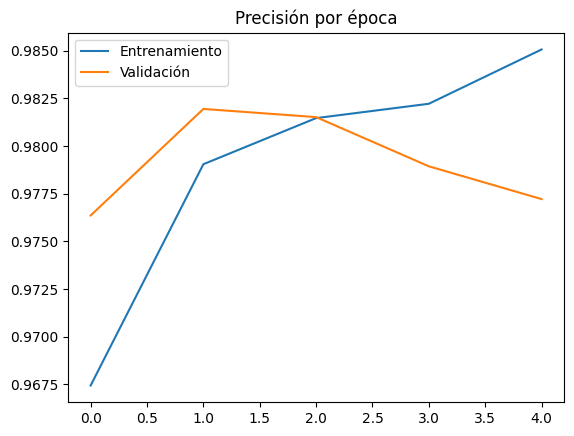

In [23]:
plt.figure()
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.legend()
plt.title('Precisión por época')
plt.show()

In [24]:
from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    img = tf.keras.preprocessing.image.load_img(fname, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0
    prediction = model.predict(img_array)[0][0]
    label = 'Positivo' if prediction > 0.5 else 'Negativo'
    print(f"{fname}: {label} ({prediction:.2f})")

Saving Figura_6.jpeg to Figura_6.jpeg
Saving Figura_7.jpg to Figura_7.jpg
Saving Figura_8.jpg to Figura_8.jpg
Saving Figura_9.jpg to Figura_9.jpg
Saving Figura_10.jpg to Figura_10.jpg
Saving Figura_11.jpg to Figura_11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Figura_6.jpeg: Negativo (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Figura_7.jpg: Positivo (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Figura_8.jpg: Positivo (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Figura_9.jpg: Negativo (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Figura_10.jpg: Positivo (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Figura_11.jpg: Negativo (0.01)


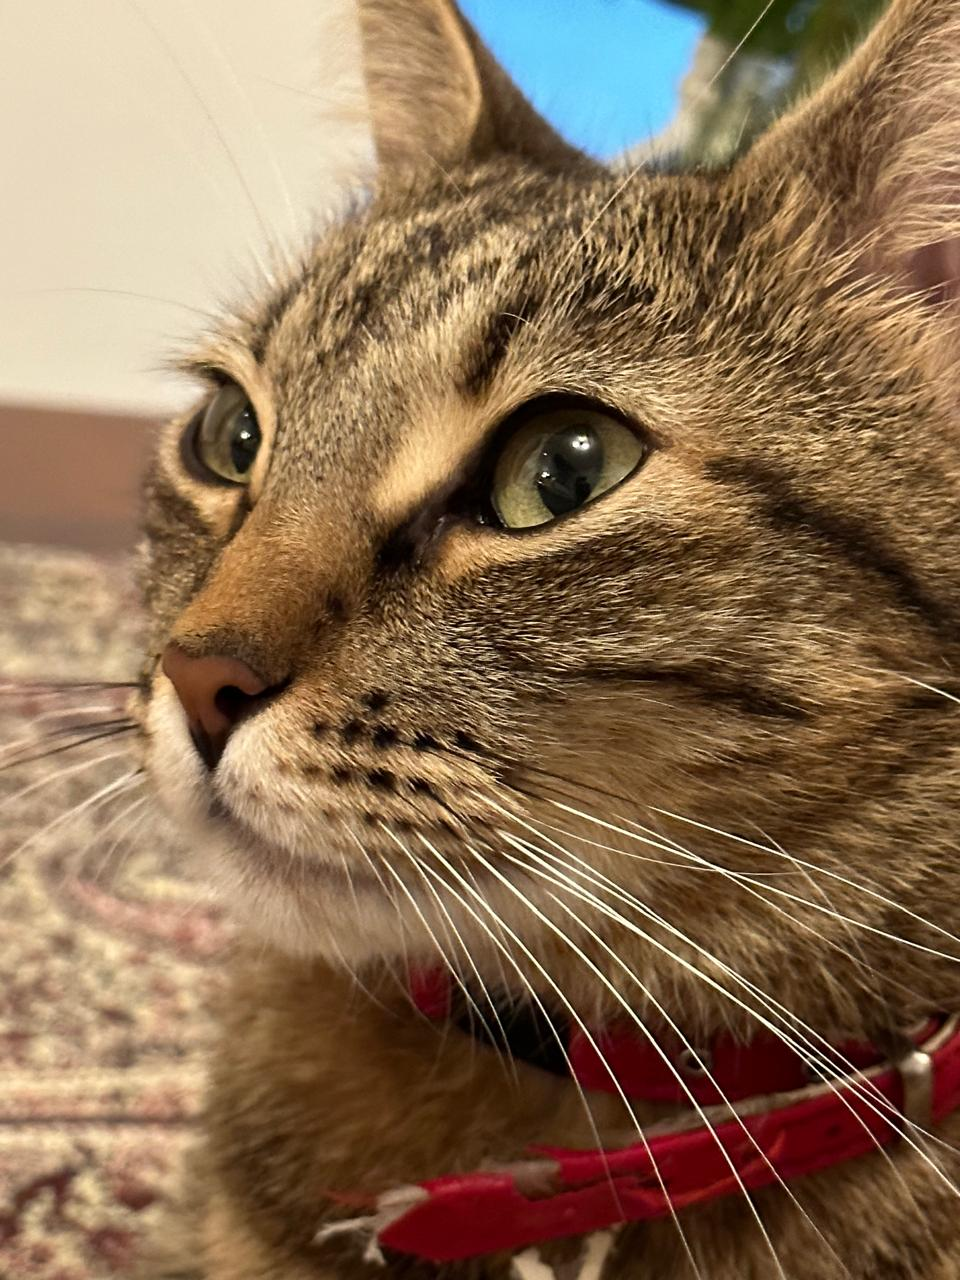

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction for Figura_6.jpeg: Cat (0.00)


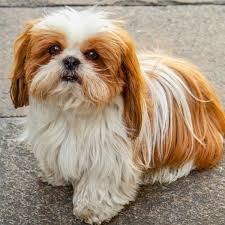

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Prediction for Figura_7.jpg: Dog (1.00)


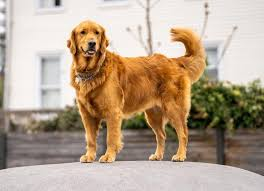

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediction for Figura_8.jpg: Dog (1.00)


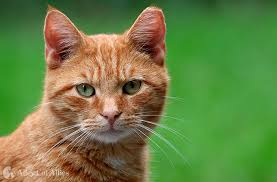

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction for Figura_9.jpg: Cat (0.00)


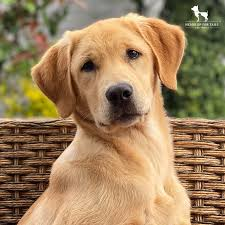

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediction for Figura_10.jpg: Dog (1.00)


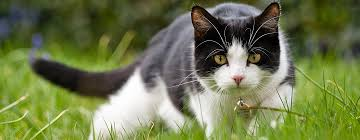

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Prediction for Figura_11.jpg: Cat (0.01)


In [25]:
# prompt: Agregar codigo, para mostrar la imagen y predecir que es

# Show the image and the prediction
from IPython.display import display
from PIL import Image

for fname in uploaded.keys():
    # Display the uploaded image
    display(Image.open(fname))

    img = tf.keras.preprocessing.image.load_img(fname, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0
    prediction = model.predict(img_array)[0][0]

    # Define labels based on the dataset
    if DATASET_NAME == 'horses_or_humans':
        label_map = {0: 'Human', 1: 'Horse'}
    elif DATASET_NAME == 'cats_vs_dogs':
        label_map = {0: 'Cat', 1: 'Dog'}
    elif DATASET_NAME == 'smile':
        label_map = {0: 'Not Smiling', 1: 'Smiling'}
    elif DATASET_NAME == 'covid_chestxray':
        label_map = {0: 'Normal', 1: 'Pneumonia/COVID-19'}
    else:
        label_map = {0: 'Negativo', 1: 'Positivo'} # Default if dataset is unknown

    predicted_label = label_map[int(round(prediction))]

    print(f"Prediction for {fname}: {predicted_label} ({prediction:.2f})")